# Neural Networks with Tensorflow

In [1]:
import addutils.toc ; addutils.toc.js(ipy_notebook=True)

In [2]:
import numpy as np
import tensorflow as tf
from time import time
from IPython.display import Image
import math
from tensorflow.examples.tutorials.mnist import input_data
import functools
import os
from addutils import css_notebook
css_notebook()

/home/matteo/anaconda3/envs/addfor_tutorials/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import bokeh.plotting as bk
from bokeh.io import push_notebook
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource
bk.output_notebook()

Loading BokehJS ...

## 1 Neural Networks

### 1.1 Neural Network Basics

What is a neuron?

A brain neuron has a structure formed by a cell body, an axon were it sends messages to other neuron and dendritic tree were it receives messages from other neuron. A neuron generates outgoing charge (throughout the axon) whenever enough charge has been received (activation).

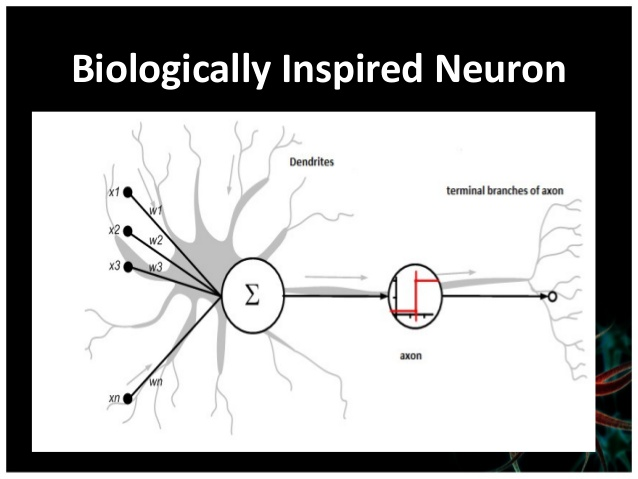

In [4]:
Image('images/neuron.jpeg', width=400, height=400)

In neural networks we use an approximation of neurons that look like this:

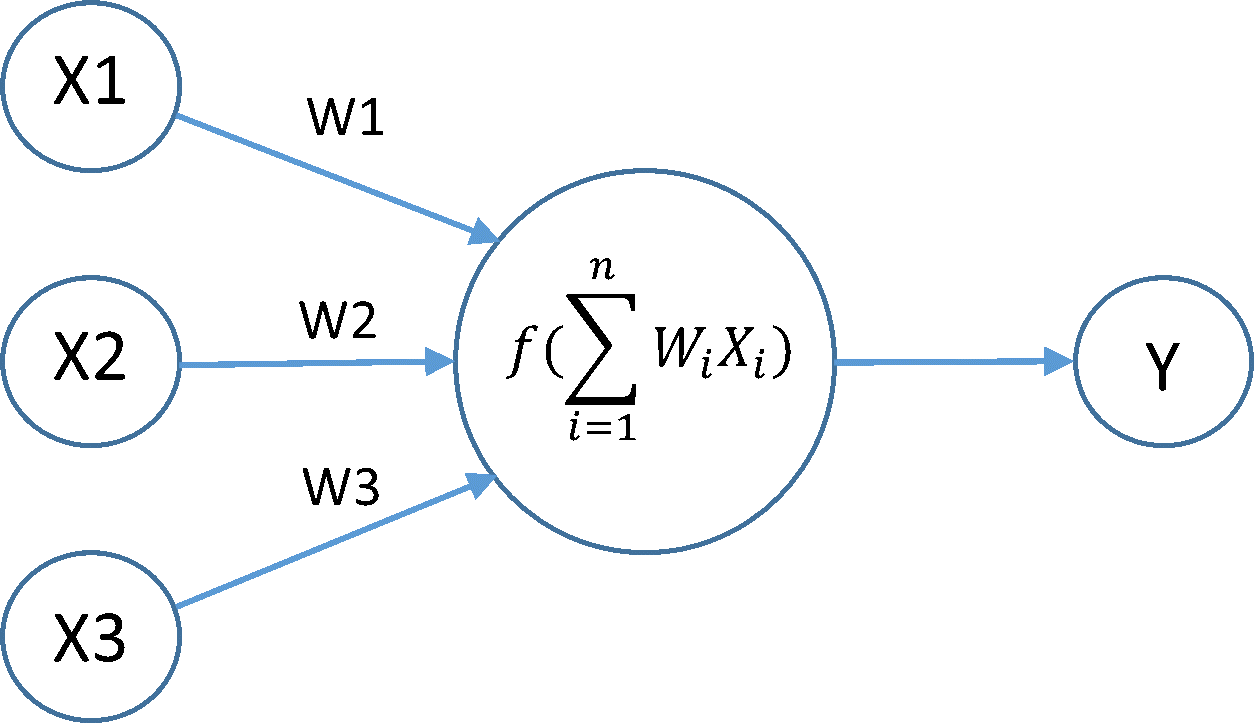

In [5]:
Image('images/Simple Neural Network.png',  width=500, height=500)

In practice they learn how to approximate functions. For example, for a classifier, it maps an input to a category $y = f(X)$. They are called networks because they combine many function together. The graph depicts how the function are composed in layers. Each function in the most basic form combines the input with a series of weights. Think about the most basic linear regression $y = W^TX+b$. $w$ is called the **weights matrix** (if we are in higher dimensions) and $b$ is the **bias vector**. If we think about the neurons of the brain are activated by a stimuli, it is not suprising that an **activation function** can be applyed to the linear combination of weights, biases and inputs. 

One example of activation function is the sigmoid that we have seen in the previous notebook.

In real life, neurons are much more complex than this, and there are many types of neural networks. So the analogy with the brain stops here. 

### 1.2 Architecture of Neural Networks

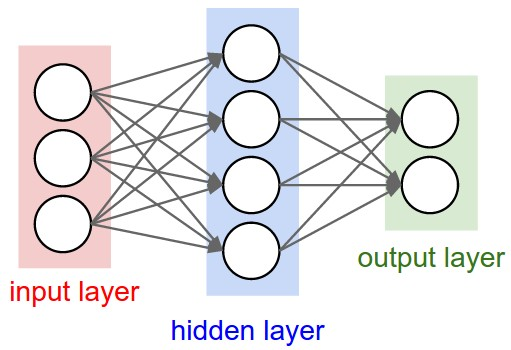

In [6]:
Image('images/neural_net.jpeg')

To define the number of layers in a network we count the number of layers that have weigths. This is a two layer network, that has one hidden layer.

The reason we use layers is that allows us to implement computation more efficiently, with matrix multiplication.

The result of all linear combinations and activation functions gives the output, and to quantify how the Neural Network is performing we define a **cost function** $C$. We have already seen two loss functions, MSE and Cross Entropy. In next section we will use MSE to understand how backpropagation work.

### 1.4 Backpropagation

#### 1.4.1 Gradient Descent

Learning in this contex reduces to finding the best weights and biases that allow the neural network to approximate the function, that is to have a small cost for all training inputs $X$. 

For the moment we will use the MSE as the cost function, but the same reasoning can be applyed to all type of cost functions. 
$$
C(W,b) = \frac{1}{2n}\sum_x \|y-f(X)\|^2
$$
Here $W$ and $b$ denotes all the weights and biases in the network, $n$ is the number of training samples in the data and $f(X)$ is the result of applying the forward pass of the network with input $X$. 

We see that $C(W,b)$ is non-negative, since every term in the sum is non-negative, furthermore, the cost becomes small, when $f(X)$ is approximately equal to the target, for all training inputs. By contrast it is not performing well when $C(W,b)$ is large, that is $f(X)$ is not close to the target for a large number of inputs. The purpose of  the training algorithm is to minimize the cost $C(W,b)$ as a function of the weights and biases. The algorithm that precisely does this is called **gradient descent**.

Quadratic cost works well in this settings, because it is a smooth function, that is making small changes to the weights and biases changes the output accordingly. That makes easy to figure out the amount of change to apply to weights and biases. 

This is a well posed problem but at the moment we are ignoring all the structure of the network, the activation function, weights and biases and so on. It turns out that we can understand a tremendous amount by ignoring most of that structure, and just concentrating on the minimization aspect. So for now we're going to forget all about the specific form of the cost function, the connection to neural networks, and so on. Instead, we're going to minimize some function, $C(v)$. This could be any real-valued function of many variables, $v=v1,v2,\ldots$. It could help to imagine $C$ as a function of just two variables: $v1$ and $v2$:

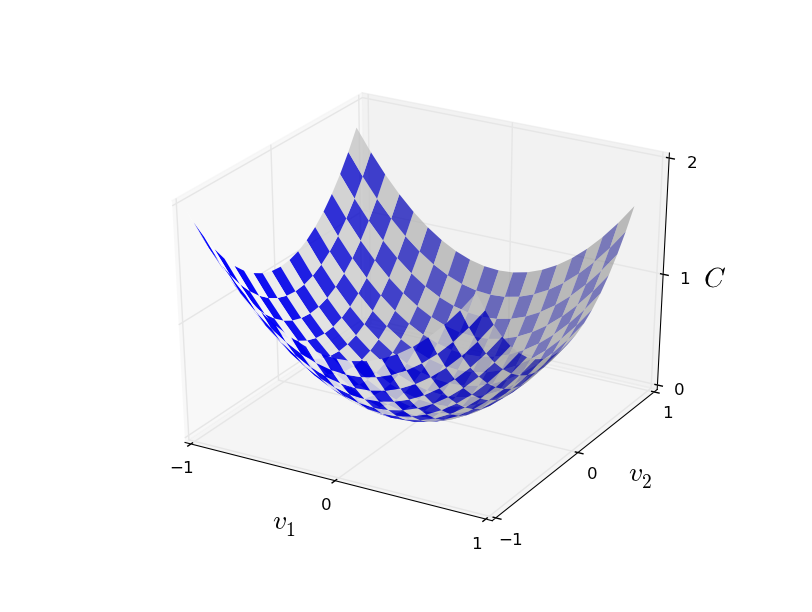

In [7]:
Image('images/valley.png',  width=500, height=500)

The objective of our algorithm is to find where $C$ achieves its global minimum. In this simple context it is easy, but in Neural Networks $C$ can be a complicated function of many variables. 

One way to solve the problem is to use calculus to try to find the minimum analytically, by computing derivatives and using them to find places where C is an extremum. This approach can be feasible when the function is of just two variables but it can be really hard when the function is composed of many variables (like that of Neural Networks), so using calculus in this case simply won't work.

Luckily gradient descent doesn't require calculus and works pretty well in this context. If we think of our function as a kind of a valley and we imagine a ball rolling down the slope of the valley, the ball will eventually roll to the bottom of the valley. How can we use this analogy to devise a method for finding the minimum of $C$? Let's think about what happens when we move the ball a small amount $\Delta v_1$ in the $v_1$ direction, and a small amount $\Delta v_2$ in the $v_2$ direction. $C$ changes as follows: 

$$\Delta C \approx \frac{\partial C}{\partial v_1} \Delta v_1 + \frac{\partial C}{\partial v_2} \Delta v_2.$$

We're going to find a way of choosing $\Delta v_1$ and $\Delta v_2$ so as to make $\Delta C$ negative, so the ball is rolling down into the valley. 

To figure out how to make such a choice it helps to define $\Delta v$ to be the vector of changes in $\Delta v \equiv (\Delta v_1, \Delta v_2)^T$. We'll also define the gradient of $C$ to be the vector of partial derivatives

$$
  \nabla C \equiv \left( \frac{\partial C}{\partial v_1}, 
  \frac{\partial C}{\partial v_2} \right)^T
$$

With these definitions, the expression for $\Delta C$ can be rewritten as $\Delta C \approx \nabla C \cdot \Delta v$, $\Delta C$ relates changes in $v$ to changes in $C$ and it lets us see how to choose $\Delta v$ so as to make $\Delta C$ negative. In particular, suppose we choose 

$$
  \Delta v = -\eta \nabla C
$$

then $\Delta C \approx -\eta \nabla C \cdot \nabla C = -\eta \|\nabla C\|^2$. Because $\|\nabla C\|^2 > 0$, this guarantees that C will always decrease, never increase, if we change $v$ according to equation above. That is exactly what we wanted (but of course remeber that is an approximation). We'll then use this equation to compute a value for $\Delta v$, then move the ball's position $v$ by that amount:

$$
  v \rightarrow v' = v -\eta \nabla C.
$$

Then we'll use this update rule again, to make another move. If we keep doing this, over and over, we'll keep decreasing C until - we hope - we reach a global minimum.

Summing up, the way the gradient descent algorithm works is to repeatedly compute the gradient $\nabla C$, and then to move in the opposite direction, "falling down" the slope of the valley. We can visualize it like this:

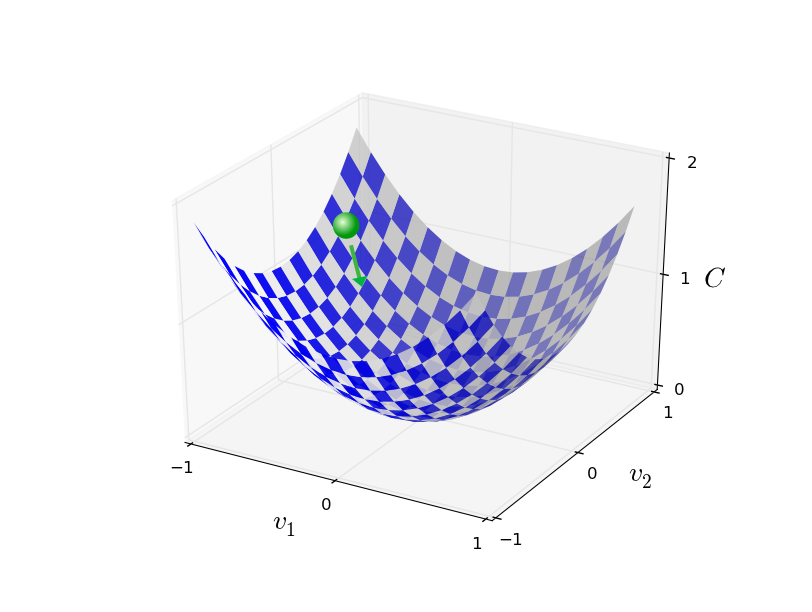

In [8]:
Image('images/valley_with_ball.png',  width=500, height=500)

To make gradient descent work correctly, we need to choose the learning rate $\eta$ to be small enough that equation $\Delta C \approx \nabla C \cdot \Delta v$ is a good approximation. In practice a lower value of $\eta$ will make small changes in $\Delta v$, while an higher value could even end us up in a worse position $\Delta C > 0$. Setting the right value of $\eta$ is tricky and in certain situations can vary over time. 

You can think of this update rule as defining the gradient descent algorithm. It gives us a way of repeatedly changing the position $v$ in order to find a minimum of the function $C$. 

How can we apply gradient descent to learn in a neural network? Position $v$ now has components $w_k$ and $b_l$, and the gradient vector $\nabla C$ has corresponding components $\partial C / \partial w_k$ and $\partial C/ \partial b_l$. Writing out the gradient descent update rule in terms of components, we have:

$$
\begin{eqnarray}
  w_k & \rightarrow & w_k' = w_k-\eta \frac{\partial C}{\partial w_k} \\
  b_l & \rightarrow & b_l' = b_l-\eta \frac{\partial C}{\partial b_l}
\end{eqnarray}
$$

By repeatedly applying this update rule we can "roll down the hill", and hopefully find a minimum of the cost function. In other words, this is a rule which can be used to learn in a neural network.

Notice that the MSE cost function has the form $C = \frac{1}{n} \sum_x C_x$, that is, it's an average over costs $C_x \equiv \frac{\|y - f(x)\|^2}{2}$ for individual training examples. In practice, to compute the gradient $\nabla C$ we need to compute the gradients $\nabla C_x$ separately for each training input, x, and then average them, $\nabla C = \frac{1}{n}
\sum_x \nabla C_x$.

#### 1.4.2 Backpropagation

In previous section we talked about gradient descent,but so far we applyed it (in previous notebook to a simple case where the parameters to optimize where only one weight vector and a bias term. What happens in a more complicated setting, for example that of a neural network? How does gradient descent work in this setting? 

To train a Neural Network in practice we use an algorithm called **backpropagation** that calculate the exact contribute of each weight of the network (that is its gradient) to the final output and update each weight (and bias) accordingly. 

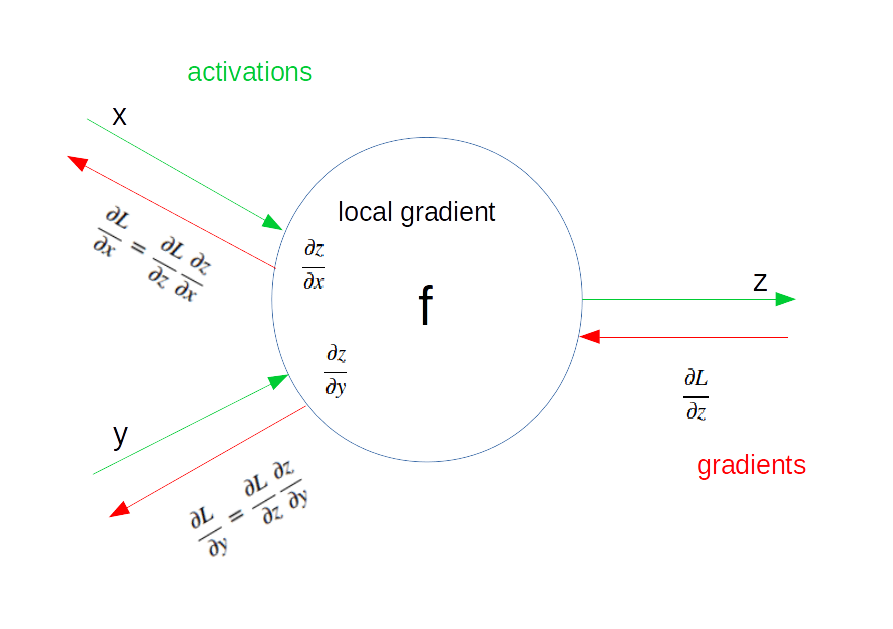

In [9]:
Image('images/gradients.png',  width=500, height=500)

This is a neuron in a computational graph of a Neural Network. Suppose we are calculating the output given a particular set of inputs $x$ and $y$. The output $z$ is passed **forward** until it reaches the output and the loss is calculated. Now we need a way to propagate the error **backward** until we can find the gradient for $x$ and $y$. Suppose that we have already the partial derivative of $z$ w.r.t. the loss $L$. What is the partial derivative of $x$ w.r.t. to $L$? Well it depdends on $f$ for sure, but since it is a composite function we can decompose its derivative with the **chain rule** that is 

$$ \frac{\partial L}{\partial x} = \frac{\partial L}{\partial z} \frac{\partial z}{\partial x}$$

The important thing to notice is that the local derivatives $\frac{\partial z}{\partial x}$ and $\frac{\partial z}{\partial y}$ can be computed right away when we recive the inputs $x$ and $y$. Then the whole process can be repeated recursively.

Then when we have all the gradients calcluated for the whole graph we can update the weights. Tensorflow does that automatically, because it knows how to compute the derivative of $f$ for each function that can be used as activation!

Remeber that $x$ and $y$ in neural networks are tensors and weights are matrices.

#### 1.4.3 Optimization functions

**Gradient descent** is a way to minimize an objective function $C(\theta)$ parameterized by a model's parameters $\theta \in R^d$ by updating the parameters in the opposite direction of the gradient of the objective function $\nabla_\theta C(\theta)$ w.r.t. to the parameters. 

The learning rate $\eta$ determines the size of the steps we take to reach a (local) minimum. The standard way to perform gradient descent is to calculate gradient for the entire training set. When the number of training inputs is very large gradient descent can take a long time or even don't fit in memory, and learning thus occurs slowly. 

**Stochastic gradient descent** in contrast perform a parameter update for each single training example. It can be faster but the result could be erratic and while it can discover new local minima, because of its fluctuations, it is usually harder to converge to such local minima.

**Mini-batch gradient descent** can be used to speed up learning. The idea is to estimate the gradient by computing them for a small sample of randomly chosen training inputs. By averaging over this small sample it turns out that we can quickly get a good estimate of the true gradient, and this helps speed up gradient descent, and thus learning.

To make these ideas more precise, mini batch gradient descent works by randomly picking out a small number m of randomly chosen training inputs. We refer to them as a *mini-batch*. Provided the sample size is large enough we expect that the average value of the gradient will be roughly equal to the average overall. Mini-batch gradient descent is typically the algorithm of choice when training a neural network and the term SGD usually is employed also when mini-batches are used

There are many optimization functions, most of them tries to improve simple stochastic gradient descent by adding momentum or other *derived* function, in order to reach (local) minima quickly or to overcome being stuck too early in bad local minima.

SGD has trouble navigating ravines, i.e. areas where the surface curves much more steeply in one dimension than in another, for example:

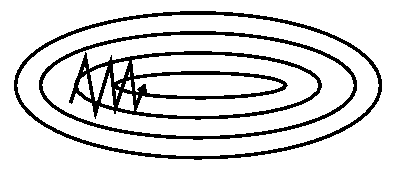

In [40]:
Image('images/without_momentum.png')

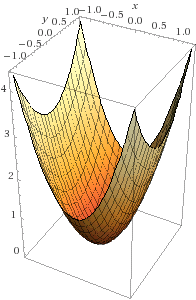

In [41]:
Image('images/without_momentum_3d.png')

**Momentum** accelerates SGD in the relevant direction and dampens oscillations. It adds a fraction of the update vector of the past time step to the current update vector:

$$
v_t = \gamma v_{t-1} + \eta \nabla_\theta C( \theta) \\
\theta = \theta - v_t
$$

The momentum term $\gamma$ is usually set to 0.9 or a similar value. The momentum term increases for dimensions whose gradients point in the same directions and reduces updates for dimensions whose gradients change directions. As a result, we gain faster convergence and reduced oscillation.

**Nesterov** is another popular gradient descent upgrade. While momentum first computes the current gradient (small blue vector) and then takes a big jump in the direction of the updated accumulated gradient (big blue vector), Nesterov first makes a big jump in the direction of the previous accumulated gradient (brown vector), measures the gradient and
then makes a correction (green vector). 
$$
v_t = \gamma v_{t-1} + \eta \nabla_\theta C( \theta - \gamma v_{t-1} ) \\  
\theta = \theta - v_t
$$

This anticipatory update increases responsiveness and prevent the update from going too fast in the wrong direction. 

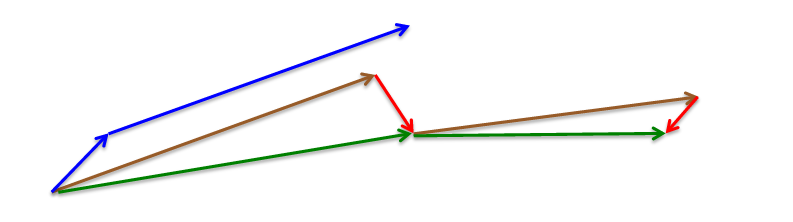

In [12]:
Image('images/nesterov.png')

**Adagrad** adapts the learning rate to the parameters, performing larger updates for infrequent parameters, and smaller updates for frequent parameters. It uses a different learning rate for every parameter at every time step, based on sum of the squares of past gradients. 
$$
g_{t, i} = \nabla_\theta C( \theta_{t, i} )\\
\theta_{t+1, i} = \theta_{t, i} - \dfrac{\eta}{\sqrt{G_{t, ii} + \epsilon}} \cdot g_{t, i}
$$

$G_t \in \mathbb{R}^{d \times d}$ is a diagonal matrix where each diagonal element $i,i$ is the sum of squares of the gradients of each parameter $i$ up to time step $t$. One key advantage with this algorithm is that eliminates the need for learning rate scheduling. It has a weak point however, every added term is positive and the accumulated sum keeps growing, this causes the learning rate to shrink and eventually become infinitesimally small.

**Adadelta** is an extension of Adagrad that seeks to reduce its aggressive, monotonically decreasing learning rate. Instead of accumulating all past squared gradients, it restricts the window of accumulated past gradients to some fixed size. The windowed accumulation forbid the denominator of Adagrad to become infinity, instead it becomes a local estimate using only recent gradients. Instead of inefficiently storing previous squared gradients, the sum of gradients is recursively defined as a decaying average of all past squared gradients. At time $t$ the accumulation becomes:

$$E[g^2]_t = \rho E[g^2]_{t-1} + (1 - \rho) g^2_t$$

As in Adagrad we require the square root of $E[g^2]_t$ in the parameter updates and this effectively becomes the RMS of past squared gradients over time:

$$
\Delta \theta_t = - \dfrac{\eta}{RMS[g]_{t}} g_t\\
\theta_{t+1} = \theta_t + \Delta \theta_t 
$$

The authors note that the units in this update (as well as in SGD, Momentum, or Adagrad) do not match, i.e. the update should have the same hypothetical units as the parameter. To realize this, they first define another exponentially decaying average, this time not of squared gradients but of squared parameter updates:

$$
E[\Delta \theta^2]_t = \rho E[\Delta \theta^2]_{t-1} + (1 - \rho) \Delta \theta^2_t
$$

Also in this case we use $RMS[\Delta \theta]_{t-1}$ and make the update proportional to:

$$
\Delta \theta_t = - \dfrac{RMS[\Delta \theta]_{t-1}}{RMS[g]_{t}} g_{t} \\
\theta_{t+1} = \theta_t + \Delta \theta_t 
$$

with $\Delta \theta_0 = 0$

**RMSprop** divides the learning rate by a decaying average of squared gradients as well as Adagrad and Adadelta. 

$$
E[g^2]_t = 0.9 E[g^2]_{t-1} + 0.1 g^2_t \\  
\theta_{t+1} = \theta_{t} - \dfrac{\eta}{\sqrt{E[g^2]_t + \epsilon}} g_{t}
$$

It was first proposed on a series of online lectures by Geoff Hinton. Hinton suggests decay to be set to 0.9, while a good default value for the learning rate is 0.001.

**Adaptive Moment Estimation (Adam)** is another method that computes adaptive learning rates for each parameter. It is similar to Adadelta and RMSprop in that it stores an exponentially decaying average of past squared gradients:
$$
m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t
$$
that serves as an estimate of the first momentum (the mean) of the gradients. In addition it calculates also an estimate of the second momentum (the uncentered variance):
$$
v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2  
$$
Since the two vectors are initlized to zero, to avoid a bias toward zero, the algorithm calculates a bias-corrected version
$$
\hat{m}_t = \dfrac{m_t}{1 - \beta^t_1} \\
\hat{v}_t = \dfrac{v_t}{1 - \beta^t_2}
$$
The update rule is similar to other methods:
$$
\theta_{t+1} = \theta_{t} - \dfrac{\eta}{\sqrt{\hat{v}_t} + \epsilon} \hat{m}_t
$$

#### 1.4.4 Optimizers in TensorFlow

We introduced all base operations of TensorFlow in previous notebook, now we talk further about optimization operators and how they are used. For example we used optimization at the end of previous notebook to classify digits:

```python
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(cost)
_, l = sess.run([optimizer, loss], feed_dict={x: x_batch, y:y_batch})
```

In a session the optimizer operation looks at all **trainable** variables that cost depends on and update them.

```python
tf.Variable(initial_value=None, trainable=True, ...)
```

Specify if a variable should be trained or not. By default, all variables are trainable. For example the global step of the training procedure should not be trained or some layer of the network could be freezed (a technique we will use in later notebooks).


There are many available optimizers in TensorFlow: 
- tf.train.GradientDescentOptimizer
- tf.train.AdagradOptimizer
- tf.train.MomentumOptimizer
- tf.train.AdamOptimizer
- tf.train.RMSPropOptimizer

### 1.4 Activation functions

There are many activation functions, perhaps two of the most popular ad the sigmoid function: 
$$
\sigma(x) = \frac{1}{1+e^{-z}}
$$

and the hyperbolic tangent: 

$$
tanh(x)
$$

Recently (2012) another activation function has become quite popular, Rectifier Linear Unit (ReLU): 

$$
max(0, x)
$$

and it is the current default choice in many modern network architectures.

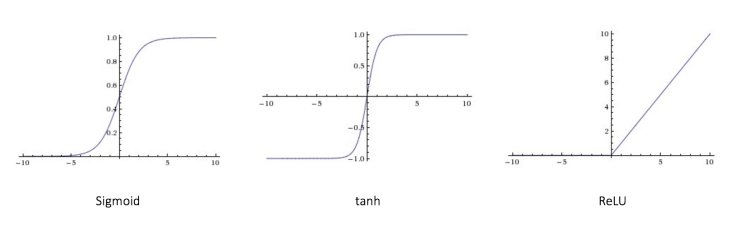

In [14]:
Image('images/activation_functions.png',  width=800, height=800)

### 1.5 Additional Resources

* [TensorFlow playground](http://playground.tensorflow.org/)
* [TensorFlow examples](https://github.com/aymericdamien/TensorFlow-Examples)
* [Colah's Blog](http://colah.github.io/)
* [Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com)
* [distill.pub](https://distill.pub/)

## 2 Classification with a Multi Layer Perceptron

### 2.1 The Data

In [15]:
mnist = input_data.read_data_sets('example_data/MNIST_data', one_hot=True)

Extracting example_data/MNIST_data/train-images-idx3-ubyte.gz
Extracting example_data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting example_data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting example_data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [16]:
# The MNIST dataset has 10 classes, representing the digits 0 through 9.
NUM_CLASSES = 10

# The MNIST images are always 28x28 pixels.
IMAGE_SIZE = 28
IMAGE_PIXELS = IMAGE_SIZE * IMAGE_SIZE

### 2.2 The Network

Now we will build the network step-by-step, we will discuss its (simple) architecture and how to built it with TensorFlow.

Our simple MLP looks like this: input -> hidden layer -> output classification

Defining a `tf.placeholder` with `None` as its first dimension indicates that the first dimension, corresponding to the batch size, can be any size. These placeholder will contain input images and labels and will be fed to the program during the training phase.

In [17]:
image_placeholder = tf.placeholder(tf.float32, shape=[None, IMAGE_PIXELS])
label_placeholder = tf.placeholder(tf.int32, shape=[None, NUM_CLASSES])

In order to provide a dictionary when feeding the placeholder, we use a small helper function.

In [18]:
def get_feed_dict(batch, place_1, place_2):
    return {place_1: batch[0], place_2: batch[1]}

The hidden layer has a number of units that can be specified with the parameter `hidden1_units` and it computes a transformation of the linear combination of inputs, weights and biases. There are a lot of transformation available in TensorFlow, but for this example we will use ReLU.

The weight matrix is initialized to random values, while the bias vector is initialized to a costant values (a smallquantity, it can be zero); it is also good practice to initialize weights of a ReLU with a slightly positive initial bias to avoid "dead neurons". A reasonable-sounding idea then might be to set all the initial weights to zero, which we expect to be the "best guess" in expectation. This turns out to be a mistake, because if every neuron in the network computes the same output, then they will also all compute the same gradients during backpropagation and undergo the exact same parameter updates. In other words, there is no source of asymmetry between neurons if their weights are initialized to be the same. It is possible and common to initialize the biases to be zero, since the asymmetry breaking is provided by the small random numbers in the weights

In [19]:
hidden1_units = 32

with tf.name_scope('hidden1'):
    weights = tf.Variable(
        tf.truncated_normal([IMAGE_PIXELS, hidden1_units], 
                            stddev=0.1 / math.sqrt(float(IMAGE_PIXELS))),
        name='weights')
    biases = tf.Variable(tf.zeros([hidden1_units]),
                         name='biases')

    hidden1 = tf.nn.relu(tf.matmul(image_placeholder, weights) + biases)

Note the use of `tf.name_scope` to define a prefix to the variables. 

The last stage compute a **softmax** transformation of the hidden layer. 

In [20]:
with tf.name_scope('softmax_linear'):
    weights = tf.Variable(
        tf.truncated_normal([hidden1_units, NUM_CLASSES],
                            stddev=1.0 / math.sqrt(float(hidden1_units))),
        name='weights')
    biases = tf.Variable(tf.zeros([NUM_CLASSES]),
                         name='biases')
    logits = tf.matmul(hidden1, weights) + biases

Now it is possible to use TensorFlow automatic differentiation to find the gradients of the cost with respect to each variable. For this example we use basic steepest gradient descent as optimizer.  **Gradient Descent** is a simple procedure, where TensorFlow simply shifts each variable a little bit in the direction that reduces the cost. This *little bit* is the **learning rate** and it is multiplied by the negative of the gradient. For this examples the learning rate is fixed at 0.05. Actually we are using **Stochastic Gradient Descent**. Stochastic means that we are not using all the data to perform a single update of the weights but we are using a subsample at a time. This subsample is called **mini batch** and it is random. Each time we exahaust the training set we can recompute another subsample and so on. Each iteration (that is each time the algorithm consumes all the dataset) is an epoch. At each epoch the function gets better.

Next we define the cost function, cross entropy in this case. 

In [21]:
learning_rate = 0.01
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,
                                                           labels=label_placeholder,
                                                           name='xentropy')
loss = tf.reduce_mean(cross_entropy, name='xentropy_mean')
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train_op = optimizer.minimize(loss)

To evaluate the model we first compute the position of the maximum entry in both predicted and real output. This corresponds to the class to which the example belongs. Then we compare the two vector to determine what fraction of the predicted output is correct.

In [22]:
correct_prediction = tf.equal(tf.argmax(tf.nn.softmax(logits),1), 
                              tf.argmax(label_placeholder,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

After we constructed the graph, we need to start a session to run it. 

In [23]:
sess = tf.Session()

Next thing to do is to initialize the variable in the session.

In [24]:
sess.run(tf.global_variables_initializer())

Ok, now we are ready to launch the training:

In [25]:
MAX_STEPS = 5000
BATCH_SIZE = 128

for i in range(MAX_STEPS):
    feed_dict = get_feed_dict(mnist.train.next_batch(BATCH_SIZE), 
                              image_placeholder, 
                              label_placeholder)
    _ = sess.run(train_op, feed_dict=feed_dict)
    if (i+1) % 500 == 0:  
        feed_dict = get_feed_dict(mnist.validation.next_batch(BATCH_SIZE), 
                                  image_placeholder, 
                                  label_placeholder)
        acc = sess.run(accuracy, feed_dict=feed_dict)
        print('Accuracy at step %s: %s' % (i+1, acc))

Accuracy at step 500: 0.8828125
Accuracy at step 1000: 0.9296875
Accuracy at step 1500: 0.90625
Accuracy at step 2000: 0.90625
Accuracy at step 2500: 0.90625
Accuracy at step 3000: 0.9140625
Accuracy at step 3500: 0.8671875
Accuracy at step 4000: 0.890625
Accuracy at step 4500: 0.953125
Accuracy at step 5000: 0.9296875


**REMARK** Epochs are calculated directly by the mnist object. Whenever the number of batches requested is greather than the number of examples it automatically updates the number of epochs. The object shuffles also the training set for better learning.

In [26]:
print(accuracy.eval(session=sess, feed_dict={image_placeholder: mnist.test.images, 
                                             label_placeholder: mnist.test.labels}))

0.9169


In [27]:
sess.close()

## 3 Structure and Logging

### 3.1 Managing experiments

#### 3.1.1 Saving and Restoring Model Variables

A good practice is to periodically save the model’s parameters after a certain number of steps so that we can restore/retrain our model from that step if need be. The `tf.train.Saver()` class allows us to do so by saving the graph’s variables in binary files. It does not save the graph! This class has basically two methods: 

```python
tf.train.Saver.save(sess, save_path, global_step=...)
```

>This method runs the ops added by the constructor for saving variables.
It requires a session in which the graph was launched.  The variables to
save must also have been initialized.

and 

```python
tf.train.Saver.restore(sess, save_path)
```

>This method runs the ops added by the constructor for restoring variables.
It requires a session in which the graph was launched.  The variables to
restore do not have to have been initialized, as restoring is itself a way
to initialize variables.

It is good practice to save parameters every $n$ number of steps.

```python
saver = tf.train.Saver()

with tf.Session() as sess:
    for step in range(training_steps): 
        sess.run([optimizer])
        
        if (step + 1) % 1000 == 0:
            saver.save(sess, 
            'checkpoint_directory/model_name',
            global_step=step)
```

In TensorFlow lingo, the step at which you save your graph’s variables is called a checkpoint. Since we will be creating many checkpoints, it’s helpful to append the number of training steps our model has gone through in a variable called global_step. It’s a very common variable to see in TensorFlow program. We first need to create it, initialize it to 0 and set it to be not trainable, since we don’t want to TensorFlow to optimize it.

```python
global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')
optimizer = tf.train.AdamOptimizer(lr).minimize(loss, global_step=global_step)
```

It is needed to tell optimizer to increment global step. This can also help your optimizer know when to decay learning rate

To restore the model from a specific checkpoint: 

```python
saver.restore(sess, 'checkpoints/name_of_the_checkpoint')
```

Note that you still need to construct the graph first. It is also possible to automatically restore the latest checkpoint: 

```python
ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/checkpoint'))

if ckpt and ckpt.model_checkpoint_path:
     saver.restore(sess, ckpt.model_checkpoint_path)
```
Checkpoint file keeps track of the latest checkpoint, restore checkpoints only when there is a valid checkpoint path.

#### 3.1.2 Log useful information with `tf.summary`

In order to visualize summary statistics during training, tensorflow has several operations:
 - tf.summary.scalar
 - tf.summary.histogram
 - tf.summary.image
 
First you need to create the summaries:
```python
with tf.name_scope("summaries"):
    tf.summary.scalar("loss", loss)
    tf.summary.scalar("accuracy", accuracy)            
    tf.summary.histogram("histogram loss", loss)
    summary_op = tf.summary.merge_all()
```
the last operation concentrate all summary in a single operation for clarity. Now you can run `summary_op` during training in a session like any other operation. Remember to write the summaries to file with a file writer. Remember to add a global step variable so the model knows what summary corresponds to what step. In the next section we will see all this in action!

### 3.2 Model structuring

A possible method for structuring models is to pass around TensorFlow objects such as training operation. Another method is to incapsulate models in objects. In next section we will see how to structure a model into objects.

In [28]:
def lazy_property(function):
    attribute = '_lazy_' + function.__name__
    
    @property
    @functools.wraps(function)
    def wrapper(self):
        if not hasattr(self, attribute):
            setattr(self, attribute, function(self))
        return getattr(self, attribute)
    return wrapper

In [29]:
class MLP:
    def __init__(self,
                 layers,
                 input_dim,
                 output_dim,
                 learning_rate,
                 batch_size=128, 
                 base_dir='temp/mnist_fc', 
                 run_dir='0', 
                 act='relu', 
                 restore=False, 
                 verbose=True, 
                 save=True):
        activations = {'relu': tf.nn.relu, 
                       'sigmoid': tf.nn.sigmoid, 
                       'tanh': tf.nn.tanh}
        self.act = activations[act]
        self.mnist = input_data.read_data_sets('example_data/MNIST_data')
        self.x = tf.placeholder(tf.float32, shape=[None, input_dim])
        self.y = tf.placeholder(tf.int64, shape=[None])
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.layers = layers
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.verbose = verbose
        self.save = save
        self.model_dir = os.path.join(base_dir, run_dir)
        self.global_step = tf.get_variable('global_step', 
                                           dtype=tf.int32, 
                                           trainable=False,
                                           initializer=0)
        self.prediction
        self.optimize
        self.accuracy
        self.saver = tf.train.Saver()
        self.sess = tf.Session()
        self.merged = tf.summary.merge_all()
        self.train_writer = tf.summary.FileWriter(os.path.join(self.model_dir, 'train'),
                                                  self.sess.graph)
        self.test_writer = tf.summary.FileWriter(os.path.join(self.model_dir, 'test'))
        if restore:
            checkpoint = tf.train.get_checkpoint_state(self.model_dir)
            if checkpoint and checkpoint.model_checkpoint_path:
                path = checkpoint.model_checkpoint_path
                self.saver.restore(self.sess, path)
            else:
                self.sess.run(tf.global_variables_initializer())
        else:
            self.sess.run(tf.global_variables_initializer())

    @lazy_property
    def prediction(self):
        return tf.nn.softmax(self.forward)

    @lazy_property
    def forward(self):
        layer = self.x
        # write few images from the input
        x_image = tf.reshape(self.x, [-1, 28, 28, 1])
        tf.summary.image('input_images', x_image, 3)
        res = [self.input_dim] + self.layers
        for i, (input_dim, output_dim) in enumerate(zip(res[:-1], res[1:])):
            layer = self._nn_layer(layer, input_dim, output_dim, 
                                   'layer'+str(i), act=self.act)
        y = self._nn_layer(layer,
                           self.layers[-1],
                           self.output_dim,
                           'output_layer',
                           act=tf.identity)
        return y
    
    @lazy_property
    def cost(self):
        with tf.name_scope('cross_entropy'):
            cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=self.y,
                                                                   logits=self.forward)
            tf.summary.scalar('cross_entropy', cross_entropy)
        return cross_entropy

    @lazy_property
    def optimize(self):
        with tf.name_scope('train_op'):
            optimizer = tf.train.GradientDescentOptimizer(self.learning_rate)
            train_op = optimizer.minimize(self.cost, global_step=self.global_step)
        return train_op

    @lazy_property
    def accuracy(self):
        with tf.name_scope('accuracy'):
            correct_prediction = tf.equal(tf.argmax(self.prediction, 1), self.y)
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
            tf.summary.scalar('accuracy', accuracy)
        return accuracy

    def close(self):
        self.sess.close()
    
    def feed_dict(self, dataset):
        """Make a TensorFlow feed_dict: maps data onto Tensor placeholders."""
        if dataset=='train':
            xs, ys = self.mnist.train.next_batch(self.batch_size)
        elif dataset=='test':
            xs, ys = self.mnist.test.images, self.mnist.test.labels
        elif dataset=='validation':
            xs, ys = self.mnist.validation.images, self.mnist.validation.labels
        return {self.x: xs, self.y: ys}
    
    @staticmethod
    def weight_variable(layer_name, shape):
        initial = tf.truncated_normal(shape, stddev=0.1)
        with tf.variable_scope(layer_name, initializer=initial, reuse=tf.AUTO_REUSE):
            return tf.get_variable('weights')

    @staticmethod
    def bias_variable(layer_name, shape):
        initial = tf.constant(0.1, shape=shape)
        with tf.variable_scope(layer_name, initializer=initial, reuse=tf.AUTO_REUSE):
            return tf.get_variable('biases')

    def _nn_layer(self,
                 input_tensor,
                 input_dim,
                 output_dim,
                 layer_name,
                 act=tf.nn.relu):
        with tf.name_scope(layer_name):
            weights = self.weight_variable(layer_name, [input_dim, output_dim])
            biases = self.bias_variable(layer_name, [output_dim])
            preactivate = tf.matmul(input_tensor, weights) + biases
            activations = act(preactivate, name='activation')
            tf.summary.histogram('weights_hist', weights)
            tf.summary.histogram('biases_hist', biases)
            tf.summary.histogram('pre_activations', preactivate)
            tf.summary.histogram('activations', activations)
            return activations

    def fit(self, steps):
        for _ in range(steps):
            i = tf.train.global_step(self.sess, self.global_step)
            if i % 10 == 0:  # Record summaries and test-set accuracy
                summary, acc = self.sess.run([self.merged, self.accuracy],
                                             feed_dict=self.feed_dict('test'))
                self.test_writer.add_summary(summary, i)
                if i % 100 == 0:
                    print('Accuracy at step %s: %s' % (i, acc)) if self.verbose else None
            if i % 100 == 99:  # Record execution stats
                run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
                run_metadata = tf.RunMetadata()
                summary, _ = self.sess.run([self.merged, self.optimize],
                                           feed_dict=self.feed_dict('train'),
                                           options=run_options,
                                           run_metadata=run_metadata)
                self.train_writer.add_run_metadata(run_metadata, 'step%d' % i)
                self.train_writer.add_summary(summary, i)
                #print('Adding run metadata for', i)
                self.saver.save(self.sess, 
                                os.path.join(self.model_dir, 'model'), 
                                global_step=self.global_step) if self.save else None
            else:  # Record a summary
                summary, _ = self.sess.run([self.merged, self.optimize],
                                           feed_dict=self.feed_dict('train'))
                self.train_writer.add_summary(summary, i)
                    
    def predict(self):
        acc, y_pred = self.sess.run([self.accuracy, self.prediction],
                                    feed_dict=self.feed_dict('validation'))
        return acc, np.argmax(y_pred, 1)

In [30]:
tf.reset_default_graph()
model = MLP([32], IMAGE_PIXELS, NUM_CLASSES, 0.01)
model.fit(1000)
acc, _ = model.predict()
print('Accuracy on validation set: {}'.format(acc))
model.close()

Extracting example_data/MNIST_data/train-images-idx3-ubyte.gz
Extracting example_data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting example_data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting example_data/MNIST_data/t10k-labels-idx1-ubyte.gz
Accuracy at step 0: 0.0743
Accuracy at step 100: 0.3019
Accuracy at step 200: 0.5238
Accuracy at step 300: 0.6444
Accuracy at step 400: 0.7136
Accuracy at step 500: 0.7565
Accuracy at step 600: 0.7803
Accuracy at step 700: 0.8037
Accuracy at step 800: 0.8186
Accuracy at step 900: 0.8318
Accuracy on validation set: 0.8425999879837036


Now it is possible to launch tensorboard with: `tensorboard --logdir=temp/mnist_fc/0`

In [31]:
tf.reset_default_graph()
model = MLP([32], IMAGE_PIXELS, NUM_CLASSES, 0.01, restore=True)
model.fit(1000)
acc, _ = model.predict()
print('Accuracy on validation set: {}'.format(acc))
model.close()

Extracting example_data/MNIST_data/train-images-idx3-ubyte.gz
Extracting example_data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting example_data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting example_data/MNIST_data/t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Restoring parameters from temp/mnist_fc/0/model-1000
Accuracy at step 1000: 0.8416
Accuracy at step 1100: 0.8498
Accuracy at step 1200: 0.8566
Accuracy at step 1300: 0.8618
Accuracy at step 1400: 0.8661
Accuracy at step 1500: 0.872
Accuracy at step 1600: 0.8743
Accuracy at step 1700: 0.8787
Accuracy at step 1800: 0.8816
Accuracy at step 1900: 0.8852
Accuracy on validation set: 0.8894000053405762


Control again with tensorboard you should see more steps.

In [32]:
from itertools import product

act_list = ['relu', 'sigmoid', 'tanh']
lr_list = [0.5, 0.01, 0.001]
layers_list = [[64], [32], [64, 32]]
for act, lr, layers in (product(act_list, lr_list, layers_list)):
    print('Now training model: {}'.format('_'.join([str(lr), str(act), str(layers)])))
    tf.reset_default_graph()
    model = MLP(layers, IMAGE_PIXELS, NUM_CLASSES, learning_rate=lr, act=act,
                run_dir='_'.join([str(lr), str(act), str(layers)]),
                save=False, verbose=False)
    model.fit(1000)
    acc, _ = model.predict()
    print('Accuracy on validation set: {}'.format(acc))
    model.close()

Now training model: 0.5_relu_[64]
Extracting example_data/MNIST_data/train-images-idx3-ubyte.gz
Extracting example_data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting example_data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting example_data/MNIST_data/t10k-labels-idx1-ubyte.gz
Accuracy on validation set: 0.9666000008583069
Now training model: 0.5_relu_[32]
Extracting example_data/MNIST_data/train-images-idx3-ubyte.gz
Extracting example_data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting example_data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting example_data/MNIST_data/t10k-labels-idx1-ubyte.gz
Accuracy on validation set: 0.9581999778747559
Now training model: 0.5_relu_[64, 32]
Extracting example_data/MNIST_data/train-images-idx3-ubyte.gz
Extracting example_data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting example_data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting example_data/MNIST_data/t10k-labels-idx1-ubyte.gz
Accuracy on validation set: 0.9634000062942505
Now training mo

Accuracy on validation set: 0.5526000261306763
Now training model: 0.001_tanh_[32]
Extracting example_data/MNIST_data/train-images-idx3-ubyte.gz
Extracting example_data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting example_data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting example_data/MNIST_data/t10k-labels-idx1-ubyte.gz
Accuracy on validation set: 0.36399999260902405
Now training model: 0.001_tanh_[64, 32]
Extracting example_data/MNIST_data/train-images-idx3-ubyte.gz
Extracting example_data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting example_data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting example_data/MNIST_data/t10k-labels-idx1-ubyte.gz
Accuracy on validation set: 0.34700000286102295


### 3.3 Considerations on simple MLP models

The performance of the simple MLP is pretty good, but what if we want to improve it? Increasing the number of layers does not improve the accuracy, but why? This is known as the vanishing or exploding gradient problems. That is, the learning procedure based on gradients is unstable if we have many layers, resulting in the last layers to learn slowly. For this reason in order to train deeper network we must use another kind of network, the **Convolutional Neural Network**. In practice to avoid the vanishing gradient problem we use a specialized network with fewer parameters, that takes advantage of spatial locality of the images.

## 4 Simplify TensorFlow

### 4.1 Estimators

Estimators are an high-level TensorFlow API that greatly simplifies machine learning programming. Estimators encapsulate the following actions:
- training
- evaluation
- prediction

If is possible to use pre-made Estimators or write custom estimators based on the tf.estimator.Estimator class. See [tensorflow estimators](https://www.tensorflow.org/programmers_guide/estimators) for more details.

### 4.2: contrib.learn

The module **learn** in the contrib section of the repository of TensorFlow was formerly known as skflow and it is meant to provide ease of use and modularity, for beginners and for integrating TensorFlow models in existing code. It has an interface similar to scikit-learn and it is possible to create a Neural Network with few line of code.

In [33]:
from tensorflow.contrib import learn
tf.logging.set_verbosity(tf.logging.ERROR)

In [34]:
classifier = learn.DNNClassifier(hidden_units=[hidden1_units, 20, 10],
                                 n_classes=NUM_CLASSES,
                                 feature_columns=learn.infer_real_valued_columns_from_input(mnist.train.images.astype(np.float32)),
                                 optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.05)) 

With just one line of code we are able to create the same neural network that took us many line of code to compute, and with just one line we can fit it.

In [35]:
classifier.fit(mnist.train.images, 
               np.argmax(mnist.train.labels, axis=1).astype(np.int64), 
               batch_size=BATCH_SIZE, 
               steps=3000) 

DNNClassifier(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._MultiClassHead object at 0x7f19607ea978>, 'hidden_units': [32, 20, 10], 'feature_columns': (_RealValuedColumn(column_name='', dimension=784, default_value=None, dtype=tf.float32, normalizer=None),), 'optimizer': <tensorflow.python.training.gradient_descent.GradientDescentOptimizer object at 0x7f19607eadd8>, 'activation_fn': <function relu at 0x7f1975f49598>, 'dropout': None, 'gradient_clip_norm': None, 'embedding_lr_multipliers': None, 'input_layer_min_slice_size': None})

The accuracy is similar to the example above.

In [36]:
accuracy_score = classifier.evaluate(x=mnist.test.images.astype(np.float32), 
                                     y=np.argmax(mnist.test.labels, axis=1).astype(np.int64))["accuracy"]
print('Accuracy: {0:f}'.format(accuracy_score))

Accuracy: 0.954500


Learn has many models, for example it is possible to create a linear classification model or even a Random Forest! It is also possible to create an highly customized model by providing a model function to an `Estimator` object. However if the model is highly complex maybe it is best to use plain TensorFlow.

---

Visit [www.add-for.com](<http://www.add-for.com/IT>) for more tutorials and updates.

This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.